In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

# Load the interaction data
data_path = 'metadata/'
interaction_df = pd.read_csv(data_path + 'interactions.csv').drop('Unnamed: 0', axis=1)
interaction_df = interaction_df.rename(columns={'FACILITYCODE': 'FacilityCode'})

In [2]:
interaction_df.columns

Index(['PERSON_ID', 'ProviderCode', 'InsertedOn', 'SurveyAnswerScore',
       'RecommendStar', 'ratings', 'num_visits', 'age', 'survey_score',
       'star_rating', 'zip_code', 'FacilityCode', 'SpecialtyCode',
       'SpecialtyDescription', 'GENDER_Female', 'GENDER_Male'],
      dtype='object')

In [3]:
# Preprocess the interaction data
interaction_df['SurveyAnswerScore'] = np.round(interaction_df['SurveyAnswerScore'], 2)
interaction_df['RecommendStar'] = np.round(interaction_df['RecommendStar'], 2)
interaction_df = interaction_df.drop('InsertedOn', axis=1)

# Aggregate the interaction data
interaction_df_mod = interaction_df.groupby(['PERSON_ID', 'ProviderCode']).agg({
    'SurveyAnswerScore': 'mean',
    'RecommendStar': 'mean',
    'num_visits': 'first',
    'age': 'mean',
    'ratings': 'mean',
    'star_rating': 'first',
    'survey_score': 'first',
    'zip_code': 'first',
    'GENDER_Female': 'first',
    'GENDER_Male': 'first',
    'FacilityCode': lambda x: list(x),
    'SpecialtyCode': lambda x: list(x)
}).reset_index()

interaction_df_mod['visit_ratings'] = 0.65 * interaction_df_mod['ratings'] + 0.35 * interaction_df_mod['num_visits']

# Generate unique integer mappings for FacilityCode and SpecialtyCode
all_facility_codes = set(code for sublist in interaction_df_mod['FacilityCode'] for code in sublist)
facility_code_map = {code: idx for idx, code in enumerate(all_facility_codes)}

all_specialty_codes = set(code for sublist in interaction_df_mod['SpecialtyCode'] for code in sublist)
specialty_code_map = {code: idx for idx, code in enumerate(all_specialty_codes)}

interaction_df_mod['FacilityCode'] = interaction_df_mod['FacilityCode'].apply(lambda codes: [facility_code_map[code] for code in codes])
interaction_df_mod['SpecialtyCode'] = interaction_df_mod['SpecialtyCode'].apply(lambda codes: [specialty_code_map[code] for code in codes])

# Prepare provider features
provider_features = interaction_df_mod.groupby('ProviderCode').agg({
    'num_visits': 'sum',
    'survey_score': 'mean',
    'star_rating': 'mean',
    'FacilityCode': lambda x: list(set([i for sublist in x for i in sublist])),
    'SpecialtyCode': lambda x: list(set([i for sublist in x for i in sublist]))
}).reset_index()

# Prepare person features
person_features = interaction_df_mod.groupby('PERSON_ID').agg({
    'age': 'first',
    'GENDER_Female': 'first',
    'GENDER_Male': 'first',
    'FacilityCode': lambda x: list(set([i for sublist in x for i in sublist])),
    'SpecialtyCode': lambda x: list(set([i for sublist in x for i in sublist]))
}).reset_index()

# Prepare edge features
edges = interaction_df_mod[['PERSON_ID', 'ProviderCode', 'visit_ratings']]

# Map IDs to integers
person_id_map = {id: idx for idx, id in enumerate(person_features['PERSON_ID'].unique())}
provider_id_map = {id: idx + len(person_id_map) for idx, id in enumerate(provider_features['ProviderCode'].unique())}
id_provider_map = {value: key for key, value in provider_id_map.items()}

# Apply mapping to the edges
edges['PERSON_ID'] = edges['PERSON_ID'].map(person_id_map)
edges['ProviderCode'] = edges['ProviderCode'].map(provider_id_map)

# Initialize the graph
G = nx.Graph()

# Add person nodes with features
for _, row in person_features.iterrows():
    G.add_node(person_id_map[row['PERSON_ID']], bipartite=0, age=row['age'], gender_female=row['GENDER_Female'], gender_male=row['GENDER_Male'], facility_codes=row['FacilityCode'], specialty_codes=row['SpecialtyCode'])

# Add provider nodes with features
for _, row in provider_features.iterrows():
    G.add_node(provider_id_map[row['ProviderCode']], bipartite=1, num_visits=row['num_visits'], survey_score=row['survey_score'], star_rating=row['star_rating'], facility_codes=row['FacilityCode'], specialty_codes=row['SpecialtyCode'])

# Add edges with features
for _, row in edges.iterrows():
    G.add_edge(row['PERSON_ID'], row['ProviderCode'], visit_ratings=row['visit_ratings'])

# Convert to adjacency matrix
adj_matrix = nx.to_numpy_array(G)
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)

# Extract node features for persons and providers
person_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
provider_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

person_features_tensor = torch.tensor([
    [d['age'], d['gender_female'], d['gender_male']] 
    for n, d in G.nodes(data=True) if n in person_nodes
], dtype=torch.float32)

provider_features_tensor = torch.tensor([
    [d['num_visits'], d['survey_score'], d['star_rating']]
    for n, d in G.nodes(data=True) if n in provider_nodes
], dtype=torch.float32)

# Create a single feature tensor
all_features = torch.cat([person_features_tensor, provider_features_tensor], dim=0)

# Prepare edge indices and labels
edge_list = np.array(G.edges)
labels = np.array([G[u][v]['visit_ratings'] for u, v in G.edges])

# Split the edges into train, validation, and test sets
train_edges, test_edges, train_labels, test_labels = train_test_split(edge_list, labels, test_size=0.2, random_state=42)
train_edges, val_edges, train_labels, val_labels = train_test_split(train_edges, train_labels, test_size=0.2, random_state=42)

train_edge_index = torch.tensor(train_edges, dtype=torch.long)
val_edge_index = torch.tensor(val_edges, dtype=torch.long)
test_edge_index = torch.tensor(test_edges, dtype=torch.long)

train_labels = torch.tensor(train_labels, dtype=torch.float32).view(-1, 1)
val_labels = torch.tensor(val_labels, dtype=torch.float32).view(-1, 1)
test_labels = torch.tensor(test_labels, dtype=torch.float32).view(-1, 1)

C:\Users\samra\AppData\Local\Temp\ipykernel_12424\2352104134.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['PERSON_ID'] = edges['PERSON_ID'].map(person_id_map)
C:\Users\samra\AppData\Local\Temp\ipykernel_12424\2352104134.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['ProviderCode'] = edges['ProviderCode'].map(provider_id_map)


In [4]:
class GNNLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.8, l2_reg=1e-5):
        super(GNNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(out_features)
        self.l2_reg = l2_reg

    def forward(self, adjacency_matrix, feature_matrix):
        h = torch.mm(adjacency_matrix, feature_matrix)
        h = self.linear(h)
        h = self.dropout(h)
        h = self.batch_norm(h)
        return F.relu(h)

class GNNModel(nn.Module):
    def __init__(self, num_facilities, num_specialties, in_features, hidden_features, out_features, embedding_dim=16, dropout=0.8, l2_reg=1e-5):
        super(GNNModel, self).__init__()
        self.facility_embedding = nn.Embedding(num_facilities, embedding_dim)
        self.specialty_embedding = nn.Embedding(num_specialties, embedding_dim)
        self.gnn1 = GNNLayer(in_features + 2 * embedding_dim, hidden_features, dropout, l2_reg)
        self.gnn2 = GNNLayer(hidden_features, out_features, dropout, l2_reg)

    def forward(self, adjacency_matrix, features, person_facility_codes, person_specialty_codes, provider_facility_codes, provider_specialty_codes):
        # Generate embeddings for facility and specialty codes
        person_facility_embeds = [torch.mean(self.facility_embedding(torch.tensor(codes)), dim=0) for codes in person_facility_codes]
        person_specialty_embeds = [torch.mean(self.specialty_embedding(torch.tensor(codes)), dim=0) for codes in person_specialty_codes]
        provider_facility_embeds = [torch.mean(self.facility_embedding(torch.tensor(codes)), dim=0) for codes in provider_facility_codes]
        provider_specialty_embeds = [torch.mean(self.specialty_embedding(torch.tensor(codes)), dim=0) for codes in provider_specialty_codes]

        # Concatenate embeddings with other features
        person_embeds = torch.cat([torch.stack(person_facility_embeds), torch.stack(person_specialty_embeds)], dim=1)
        provider_embeds = torch.cat([torch.stack(provider_facility_embeds), torch.stack(provider_specialty_embeds)], dim=1)

        # Combine features with embeddings
        person_features = torch.cat([features[:len(person_embeds)], person_embeds], dim=1)
        provider_features = torch.cat([features[len(person_embeds):], provider_embeds], dim=1)

        features = torch.cat([person_features, provider_features], dim=0)

        # Apply GNN layers
        h = self.gnn1(adjacency_matrix, features)
        h = self.gnn2(adjacency_matrix, h)
        return h

In [5]:
train_loss_data=[] ; val_loss_data = []

In [6]:

def train_gcn(model, adj_matrix, features, person_facility_codes, person_specialty_codes, provider_facility_codes, provider_specialty_codes, train_edge_index, train_labels, val_edge_index, val_labels, epochs=200, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    patience = 25
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        logits = model(adj_matrix, features, person_facility_codes, person_specialty_codes, provider_facility_codes, provider_specialty_codes)

        train_edge_logits = logits[train_edge_index[:, 0]] + logits[train_edge_index[:, 1]]
        train_loss = criterion(train_edge_logits, train_labels)
        train_loss_data.append(train_loss.detach().numpy())

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_logits = model(adj_matrix, features, person_facility_codes, person_specialty_codes, provider_facility_codes, provider_specialty_codes)
            val_edge_logits = val_logits[val_edge_index[:, 0]] + val_logits[val_edge_index[:, 1]]
            val_loss = criterion(val_edge_logits, val_labels)
            val_loss_data.append(val_loss.detach().numpy())

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_gcn_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    model.load_state_dict(torch.load('best_gcn_model.pth'))
    return model



In [7]:
in_feats = all_features.shape[1]
hidden_feats = 32
out_feats = 1

In [19]:
in_feats

3

In [8]:
person_facility_codes = [d['facility_codes'] for n, d in G.nodes(data=True) if n in person_nodes]
person_specialty_codes = [d['specialty_codes'] for n, d in G.nodes(data=True) if n in person_nodes]
provider_facility_codes = [d['facility_codes'] for n, d in G.nodes(data=True) if n in provider_nodes]
provider_specialty_codes = [d['specialty_codes'] for n, d in G.nodes(data=True) if n in provider_nodes]

In [9]:
num_facilities = len(interaction_df['FacilityCode'].unique().tolist())
num_specialties = len(interaction_df['SpecialtyCode'].unique().tolist())


In [10]:
gcn_model = GNNModel(num_facilities, num_specialties, in_feats, hidden_feats, out_feats)
gcn_model = train_gcn(gcn_model, adj_matrix, all_features, person_facility_codes, person_specialty_codes, provider_facility_codes, provider_specialty_codes, train_edge_index, train_labels, val_edge_index, val_labels)


Epoch 1, Train Loss: 9.707258224487305, Val Loss: 6.431312561035156
Epoch 2, Train Loss: 9.446014404296875, Val Loss: 6.469573497772217
Epoch 3, Train Loss: 9.345853805541992, Val Loss: 6.35421085357666
Epoch 4, Train Loss: 9.381152153015137, Val Loss: 7.435247421264648
Epoch 5, Train Loss: 8.92664623260498, Val Loss: 8.044880867004395
Epoch 6, Train Loss: 9.335492134094238, Val Loss: 8.642428398132324
Epoch 7, Train Loss: 9.120208740234375, Val Loss: 8.82380485534668
Epoch 8, Train Loss: 9.964761734008789, Val Loss: 8.943115234375
Epoch 9, Train Loss: 9.000967979431152, Val Loss: 8.995809555053711
Epoch 10, Train Loss: 8.298870086669922, Val Loss: 8.982094764709473
Epoch 11, Train Loss: 8.109703063964844, Val Loss: 8.90512466430664
Epoch 12, Train Loss: 7.443703651428223, Val Loss: 8.758931159973145
Epoch 13, Train Loss: 7.328162670135498, Val Loss: 8.602166175842285
Epoch 14, Train Loss: 7.1781325340271, Val Loss: 8.423453330993652
Epoch 15, Train Loss: 6.876316547393799, Val Loss: 8

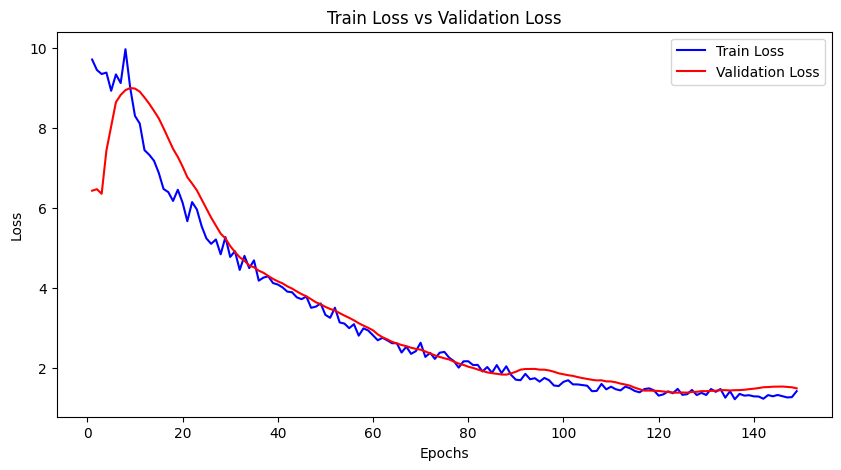

In [11]:


# Assuming train_loss_data and val_loss_data are already defined
# Example:
# train_loss_data = [9.74, 9.60, ...]
# val_loss_data = [5.71, 7.68, ...]

epochs = range(1, len(train_loss_data) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_data, 'b-', label='Train Loss')
plt.plot(epochs, val_loss_data, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()


In [14]:
def calculate_ndcg(model, adj_matrix, features, person_facility_codes, person_specialty_codes, provider_facility_codes, provider_specialty_codes, test_edge_index, test_labels):
    model.eval()
    with torch.no_grad():
        logits = model(adj_matrix, features, person_facility_codes, person_specialty_codes, provider_facility_codes, provider_specialty_codes)
        test_edge_logits = logits[test_edge_index[:, 0]] + logits[test_edge_index[:, 1]]
        test_edge_logits = test_edge_logits.cpu().numpy().reshape(1, -1)
        test_labels = test_labels.cpu().numpy().reshape(1, -1)
        return ndcg_score(test_labels, test_edge_logits)

# Assume test_edge_index and test_labels are already defined
ndcg = calculate_ndcg(gcn_model, adj_matrix, all_features, person_facility_codes, person_specialty_codes, provider_facility_codes, provider_specialty_codes, test_edge_index, test_labels)
print(f'GCN NDCG Score: {ndcg}')


GCN NDCG Score: 0.9338621470256401


In [15]:
torch.save(gcn_model.state_dict(), 'models/gcn_reco_v2.pth')

In [18]:
gcn_model = GNNModel(num_facilities, num_specialties,in_feats, hidden_feats, out_feats)
gcn_model.load_state_dict(torch.load('models/gcn_reco_v2.pth'))
gcn_model.eval()

GNNModel(
  (facility_embedding): Embedding(53, 16)
  (specialty_embedding): Embedding(89, 16)
  (gnn1): GNNLayer(
    (linear): Linear(in_features=35, out_features=32, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
    (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gnn2): GNNLayer(
    (linear): Linear(in_features=32, out_features=1, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
    (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)